# Lab 9a: PCA for Face Recognition
    
Following the demo for this unit, we will explore further the use of PCA for feature dimension reduction for classification. We will use a 2-layer neural net on the PCA coefficients. We will practice optimizing the classificaiton parameters (the number of PCA components and the number of hidden nodes in the NN classifier). We will furthermore compare this approach with using convolutional neural net on raw images.

Through the lab, you will learn to:

* Perform PCA on the a face dataset to find the PC components
* Evaluate the effect of using different nubmer of principle components for data representation and classification.
* Optimize the number of PC coefficients and classifier parameters together to maximize classification accuracy.
* Understand the impact of training data size on the feature and classification method selection.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Import the flw_people dataset. 
# Select only those people with at least 100 instances 
# Reduce the face image size by 0.4

# TO DO
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.6)

In [3]:
# Save the face images in a datamatrix X and the labels and corresponding names in a datamatrix y and target_names
# Furthermore, determine the number of samples and the image size 
# Determine the number of different faces (number of classes)

# TO DO
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

# Labels of images 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Image size     = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number faces   = {0:d}".format(n_samples))
print("Number classes = {0:d}".format(n_classes))

Image size     = 75 x 56 = 4200 pixels
Number faces   = 1140
Number classes = 5


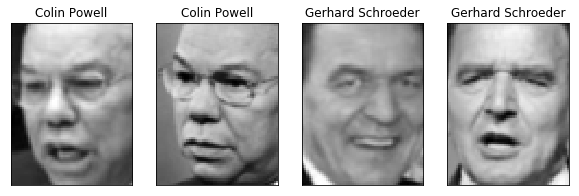

In [4]:
# Plot some sample images to make sure your data load is correct
def plt_face(x):
    global h
    global s
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

In [5]:
# Split the data into a training set and test set with 50% data for training. 
# Use "stratify" option to make sure the training data and test data have same 
# proportion of images from different faces
# print the number of samples in the training data

# TO DO 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y, random_state=43)
ntr_samples, _ = X_train.shape
nts_samples, _ = X_test.shape
print('The number of samples in the trainning data is %d' % ntr_samples)

The number of samples in the trainning data is 570


In [6]:
# Perfom PCA on the training data to derive the principle components (PCs) and the PCA coefficients 
# You can directly use the PCA class in PCA package or use SVD.
# Remember that you need to remove the mean from the data first
# Also you should rescale the PCs so that the PCA coefficients all have unit variance
# Determine the total number of PCs

# TO DO 
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Utr,Str,Vtr = np.linalg.svd(Xtr, full_matrices=False)

First let us construct a 2-layer neural net classifier that uses npc= 100 PCA coefficients to classify the faces.  Set up your training and testing data to contain npc PCA coefficients using the previously determined principle components. You should directly use matrix multiplication (i.e. projecting original data to the first 100 principle components you found previously) to find the coefficients rather then using the pca.transform( ) method.


In [7]:
# TO DO
npc = 100

eigenface = Vtr[:npc,:]
Xtr_pca = Xtr.dot(eigenface.T)
Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(ntr_samples)

Xts = X_test - Xtr_mean[None,:]
Xts_pca = Xts.dot(eigenface.T)
Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(ntr_samples)

Now set up and compile a NN model with number of hidden nodes nnode=100 and a output layer, and then fit the model to the training data. Use 'relu' for the activation for the hidden layer and use 'softmax' for the output layer. Using `sparse_categorical_crossentropy` for the loss. Use `accuracy` as the metrics. You can choose to do a small number of epochs (=10) with batch size =100.  Determine the accuracy on the validation set.

In [8]:
# TO DO
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

import keras.backend as K
K.clear_session()

nin = Xtr_pca_s.shape[1]  # dimension of input data
nnode = 100     # number of hidden units
nout = int(np.max(y_train)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(nnode, input_shape=(nin,), activation='relu', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

from keras import optimizers

batch_size = 100
epochs = 10
lrate = 0.006
decay = lrate/epochs

opt = optimizers.Adam(lr=lrate)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(Xtr_pca_s, y_train, batch_size=batch_size, epochs=epochs, validation_data=(Xts_pca_s,y_test))

Using TensorFlow backend.


Train on 570 samples, validate on 570 samples
Epoch 1/10
570/570 [==============================] - 0s 298us/step - loss: 1.6609 - acc: 0.3404 - val_loss: 1.1812 - val_acc: 0.5439
Epoch 2/10
570/570 [==============================] - 0s 27us/step - loss: 0.8411 - acc: 0.7158 - val_loss: 0.8495 - val_acc: 0.7368
Epoch 3/10
570/570 [==============================] - 0s 25us/step - loss: 0.4671 - acc: 0.9316 - val_loss: 0.6571 - val_acc: 0.8123
Epoch 4/10
570/570 [==============================] - 0s 25us/step - loss: 0.2747 - acc: 0.9667 - val_loss: 0.5579 - val_acc: 0.8316
Epoch 5/10
570/570 [==============================] - 0s 27us/step - loss: 0.1630 - acc: 0.9877 - val_loss: 0.5090 - val_acc: 0.8404
Epoch 6/10
570/570 [==============================] - 0s 26us/step - loss: 0.1019 - acc: 0.9912 - val_loss: 0.4880 - val_acc: 0.8474
Epoch 7/10
570/570 [==============================] - 0s 25us/step - loss: 0.0639 - acc: 0.9982 - val_loss: 0.4757 - val_acc: 0.8579
Epoch 8/10
570/570 [==

Now try to identify the best number of PCs and the best number of hidden nodes in the NN classifer that can achieve the highest validation accuracy. 
You can set the range of PCs and nubmer of hidden nodes as below.

nnodes = [50,100,150,200, 250],
npcs = [50,100,150,200]


In [9]:
# Set up an array to store accuracy for different nnode and npcs
# TO DO
nnodes = [50,100,150,200,250]
npcs = [50,100,150,200]

In [10]:
# Loop through the combinations to find the accuracy for each combination
# For each possible combination of `nnode` and `npc`, set up and fit the model 
# using features containing only coefficents corresponding to npc coefficients.

# TO DO 
K.clear_session()

val_acc = np.zeros((len(npcs),len(nnodes)))
for i, npc in enumerate(npcs):
    eigenface = Vtr[:npc,:]
    Xtr_pca = Xtr.dot(eigenface.T)
    Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(ntr_samples)
    
    Xts = X_test - Xtr_mean[None,:]
    Xts_pca = Xts.dot(eigenface.T)
    Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(ntr_samples)
    for j, nnode in enumerate(nnodes):
        nin = Xtr_pca_s.shape[1]  # dimension of input data
        nout = int(np.max(y)+1)    # number of outputs = 10 since there are 10 classes
        model = Sequential()
        model.add(Dense(nnode, input_shape=(nin,), activation='relu', name='hidden'))
        model.add(Dense(nout, activation='softmax', name='output'))

        from keras import optimizers

        opt = optimizers.Adam(lr=lrate)
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        hist = model.fit(Xtr_pca_s, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(Xts_pca_s,y_test))
        val_acc[i,j] = hist.history['val_acc'][-1]

In [11]:
# Determine the npc and nnode that provides the highest validation accuracy 
# TO DO 
re = np.where(val_acc == np.max(val_acc))
print('# The npc and nnode that provides the highest validation accuracy:')
print('npc: %d' % npcs[re[0][0]])
print('nnode: %d' % nnodes[re[1][0]])
print('validation accuracy: %.4f%%' % (np.max(val_acc)*100))

# The npc and nnode that provides the highest validation accuracy:
npc: 100
nnode: 100
validation accuracy: 87.7193%


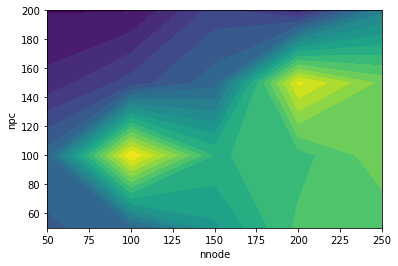

In [12]:
# Produce a contour plot of the accuracy using different nnode and npc combincations
# TO DO
plt.contourf(nnodes, npcs, val_acc, 20)
plt.xlabel('nnode')
plt.ylabel('npc')
plt.show()

## Now let us compare the PCA+NN with applying a CNN on the raw image data only. 

Note that you should scale your image data to between 0 and 1. And you should reshape your training and testing data according to image width and height


In [13]:
# Data preparation for input to CNN
# TO DO
import keras

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train = x_train.reshape(ntr_samples, h, w, 1)
x_test = x_test.reshape(nts_samples, h, w, 1)
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [14]:
# Set up a CNN model
# You can use 2 conv2D layer, each with kernel size of 5x5, each followed by a pooling layer with strides of 2
# For this part, let both conv2D layer generate 16 channels. 
# The Conv layer should be followed by a flatten layer and two dense layers. 
# The first dense layer should produce 200 outputs. 
# The last dense layer is the output layer with n_classes output using 'softmax' activation.
# Print model summary to verify it follows the desired structure and compile the model

# TO DO 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 100
epochs = 40
lrate_cnn = 0.001
decay_cnn = lrate_cnn/epochs

K.clear_session()

model = Sequential()

model.add(Conv2D(16, 
                 (5, 5), 
                 padding='valid', 
                 input_shape=x_train.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate_cnn, decay=decay_cnn)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 71, 52, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 22, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2640)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               528200    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total para

In [15]:
# Fit the model using batch size=100, epochs = 40
# Print the accuracy on the validation set

# TO DO 
np.random.seed()
hist_cnn = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 570 samples, validate on 570 samples
Epoch 1/40
570/570 [==============================] - 2s 4ms/step - loss: 1.4895 - acc: 0.4614 - val_loss: 1.4468 - val_acc: 0.4649
Epoch 2/40
570/570 [==============================] - 2s 3ms/step - loss: 1.4291 - acc: 0.4649 - val_loss: 1.4100 - val_acc: 0.4649
Epoch 3/40
570/570 [==============================] - 2s 3ms/step - loss: 1.3995 - acc: 0.4649 - val_loss: 1.3905 - val_acc: 0.4649
Epoch 4/40
570/570 [==============================] - 2s 3ms/step - loss: 1.3805 - acc: 0.4649 - val_loss: 1.3626 - val_acc: 0.4649
Epoch 5/40
570/570 [==============================] - 2s 3ms/step - loss: 1.3490 - acc: 0.4649 - val_loss: 1.3306 - val_acc: 0.4649
Epoch 6/40
570/570 [==============================] - 2s 3ms/step - loss: 1.3120 - acc: 0.4772 - val_loss: 1.2679 - val_acc: 0.4684
Epoch 7/40
570/570 [==============================] - 2s 3ms/step - loss: 1.2363 - acc: 0.5123 - val_loss: 1.1765 - val_acc: 0.5123
Epoch 8/40
570/570 [==========

How do the result compared with the PCA+NN method? (If you did right, they should be similar, with PCA+NN being slightly better. If you used more training data (e.g. 75%) and you trained the CNN with more epochs, CNN method may get better). 

A: The result of the two methods are similar. Since I have adjusted the parameters well for CNN, the result of CNN is slightly better. Generally speaking, CNN may have a higher upperbound than PCA+NN, while it requires more training data, more epochs, good parameters and more time.

## Repeat the above using a small dataset

Instead of using 50% of the total data for training, let us assume you have only 10% of the total data for training. Repeat both the PCA+NN and the CNN method, to see which one gives you better results. 

Note that with only 10% data for training, the range of the npc has to be set to be below the total number of training samples. 

For the CNN model, because you have small number of training samples, you cannot train a network with a large number of parameters reliably. Instead of producing 16 channels for each of the two conv2D layers, configure the model to produce only 8 channels each. 

PCA+NN PART START
The number of samples in the trainning data is 114
# The npc and nnode that provides the highest validation accuracy:
npc: 90
nnode: 250
validation accuracy: 73.8791%


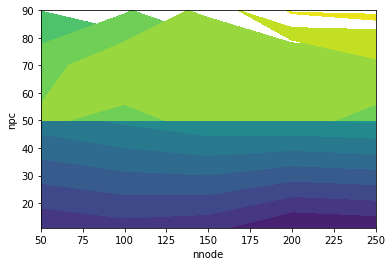

PCA+NN PART END
------------------
CNN PART START
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 71, 52, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 22, 8)         1608      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 11, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1320)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               264200    
_________________________________________________________________
dense_2 (Dense)           

In [16]:
## TO DO
# PCA+NN PART
print('PCA+NN PART START')
# Import the flw_people dataset. 
# Select only those people with at least 100 instances 
# Reduce the face image size by 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, stratify = y, random_state=43)
ntr_samples, _ = X_train.shape
nts_samples, _ = X_test.shape
print('The number of samples in the trainning data is %d' % ntr_samples)

# Perfom PCA on the training data to derive the principle components (PCs) and the PCA coefficients 
# You can directly use the PCA class in PCA package or use SVD.
# Remember that you need to remove the mean from the data first
# Also you should rescale the PCs so that the PCA coefficients all have unit variance
# Determine the total number of PCs
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Utr,Str,Vtr = np.linalg.svd(Xtr, full_matrices=False)

# Set up an array to store accuracy for different nnode and npcs
nnodes = [50,100,150,200,250]
npcs = [50,70,90,11]

# Loop through the combinations to find the accuracy for each combination
# For each possible combination of `nnode` and `npc`, set up and fit the model 
# using features containing only coefficents corresponding to npc coefficients.
K.clear_session()

val_acc = np.zeros((len(npcs),len(nnodes)))
for i, npc in enumerate(npcs):
    eigenface = Vtr[:npc,:]
    Xtr_pca = Xtr.dot(eigenface.T)
    Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(ntr_samples)
    
    Xts = X_test - Xtr_mean[None,:]
    Xts_pca = Xts.dot(eigenface.T)
    Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(ntr_samples)
    for j, nnode in enumerate(nnodes):
        nin = Xtr_pca_s.shape[1]  # dimension of input data
        nout = int(np.max(y)+1)    # number of outputs = 10 since there are 10 classes
        model = Sequential()
        model.add(Dense(nnode, input_shape=(nin,), activation='relu', name='hidden'))
        model.add(Dense(nout, activation='softmax', name='output'))

        from keras import optimizers

        opt = optimizers.Adam(lr=lrate)
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        hist = model.fit(Xtr_pca_s, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(Xts_pca_s,y_test))
        val_acc[i,j] = hist.history['val_acc'][-1]
        
# Determine the npc and nnode that provides the highest validation accuracy 
re = np.where(val_acc == np.max(val_acc))
print('# The npc and nnode that provides the highest validation accuracy:')
print('npc: %d' % npcs[re[0][0]])
print('nnode: %d' % nnodes[re[1][0]])
print('validation accuracy: %.4f%%' % (np.max(val_acc)*100))

# Produce a contour plot of the accuracy using different nnode and npc combincations
plt.contourf(nnodes, npcs, val_acc, 20)
plt.xlabel('nnode')
plt.ylabel('npc')
plt.show()

print('PCA+NN PART END')
print('------------------')
# CNN PART
print('CNN PART START')
# Data preparation for input to CNN

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train = x_train.reshape(ntr_samples, h, w, 1)
x_test = x_test.reshape(nts_samples, h, w, 1)
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# Set up a CNN model
# You can use 2 conv2D layer, each with kernel size of 5x5, each followed by a pooling layer with strides of 2
# For this part, let both conv2D layer generate 8 channels. 
# The Conv layer should be followed by a flatten layer and two dense layers. 
# The first dense layer should produce 200 outputs. 
# The last dense layer is the output layer with n_classes output using 'softmax' activation.
# Print model summary to verify it follows the desired structure and compile the model
K.clear_session()

model = Sequential()

model.add(Conv2D(8, 
                 (5, 5), 
                 padding='valid', 
                 input_shape=x_train.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (5, 5), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate_cnn, decay=decay_cnn)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# Fit the model using batch size=100, epochs = 40
# Print the accuracy on the validation set
batch_size = 100
epochs = 40

np.random.seed()
hist_cnn = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

print('CNN PART END')
print('------------------')

Q: How does CNN compare with PCA+NN with the small training set? Why?

A: With the small trainning set, PCA+NN performs better than CNN. This is partly because the PCA process has already reduce the dimension in the direction of the greatest variance. As a result, although it may kill some gentle features, it do make most of the features more obvious and easier to be learned by the neural network. Thus, it can reach a better result with the small training set. 